# Plotting 1D distribution of the charm score

In [1]:
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist
import pickle

#Plot settings
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
#mpl.rcParams['lines.linewidth'] = 5

from plotter import *

#Dataset parameters
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

with open('xsec.json') as f:
    xs = json.load(f)

with open('pmap.json') as f:
    pmap = json.load(f)

systematics = ['nominal',
               'jet_triggerUp','jet_triggerDown',
               'btagWeightUp','btagWeightDown','btagEffStatUp','btagEffStatDown',
               'UESUp','UESDown','JESUp','JESDown','JERUp','JERDown',
              ]

## 1. Processing plots after Jennet's run

Coffea outputs: /eos/uscms/store/user/jennetd/may-2021/vh-charm-category/outfiles

In [2]:
year = '2017'
outsum = processor.dict_accumulator()
nfiles = len(subprocess.getoutput("ls ../infiles-split/"+year+"*.json").split())
#nfiles = 10

# Check if pickle exists, and don't re-create it if it does
repickle=True

picklename = 'pickles/{}_CScores.pkl'.format(year)
if os.path.isfile(picklename):
    repickle=False

In [3]:
# Load all files - this takes a while
if repickle:
    for n in range(1, nfiles+1):

        with open('../infiles-split/{}_{}.json'.format(year, n)) as f:
            infiles = json.load(f)
    
        filename = '/myeosdir/vh-charm-category/outfiles/{}_{}.coffea'.format(year, n)
        #filename = 'outfiles/'+year+'_'+str(n)+'.coffea' #For local testing
        
        if os.path.isfile(filename):
            out = util.load(filename)
            outsum.add(out)
        else:
            print('Missing file: '+str(n), infiles.keys())
            #print("File " + filename + " is missing")
        
    scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
    outsum['templates-vh-2'].scale(scale_lumi, 'dataset')
    
    # Use pmap to group the datasets together
    templates = outsum['templates-vh-2'].group('dataset', hist.Cat('process', 'Process'), pmap)

    outfile = open(picklename, 'wb')
    pickle.dump(templates, outfile, protocol=-1)
    outfile.close()

Missing file: 2416 dict_keys(['WJetsToLNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8'])


/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:376: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7fc8be3f9490>
  warnings.warn(


In [4]:
# Read the histogram from the pickle file
charm_scores = pickle.load(open(picklename,'rb'))

In [5]:
#Print the axes just to check
charm_scores

<Hist (process,region,msd1,ddb1,msd2,ddb2,ddc2) instance at 0x7f6ac8711d60>

### 1D plots

Text(0.5, 1.0, 'ZH')

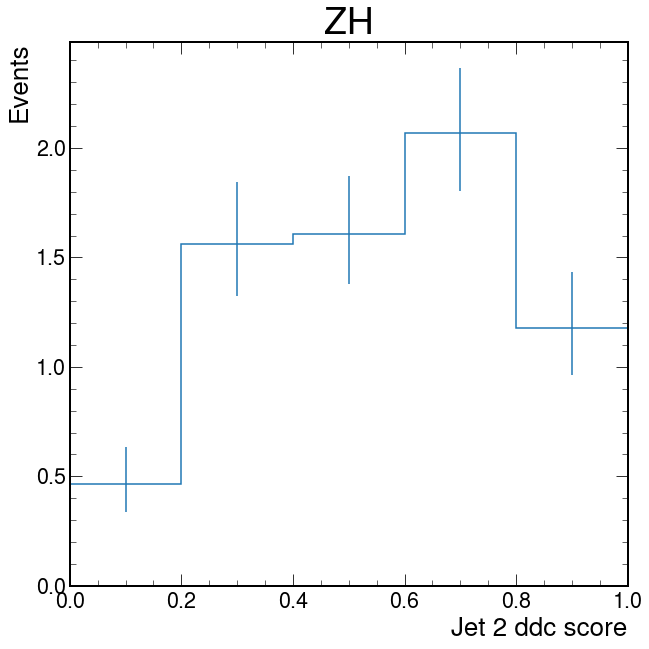

In [7]:
# check intergrals
hist.plot1d(charm_scores.sum('msd1','ddb1','msd2','ddb2').integrate('region','signal').integrate('process','ZH'))
plt.legend([])
plt.title('ZH')

Text(0.5, 1.0, 'WH')

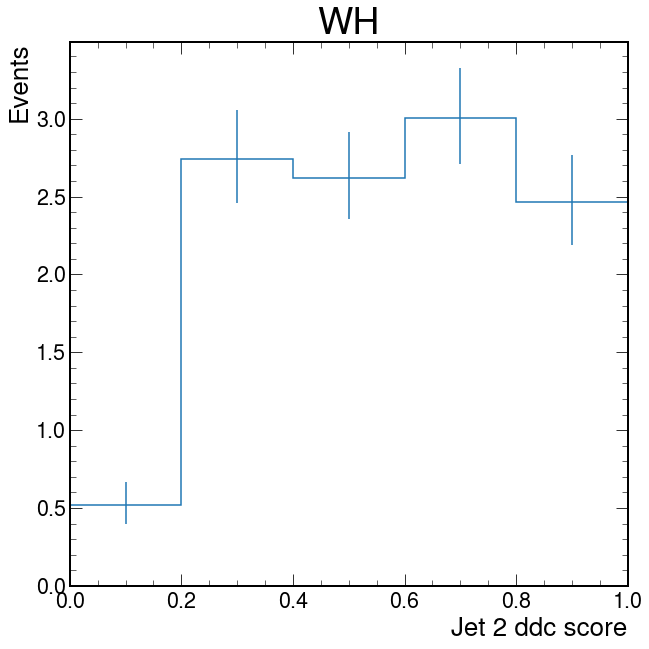

In [8]:
# check intergrals
hist.plot1d(charm_scores.sum('msd1','ddb1','msd2','ddb2').integrate('region','signal').integrate('process','WH'))
plt.legend([])
plt.title('WH')

### 2D plots

Text(0, 1, 'Jet 2 DDCvB')

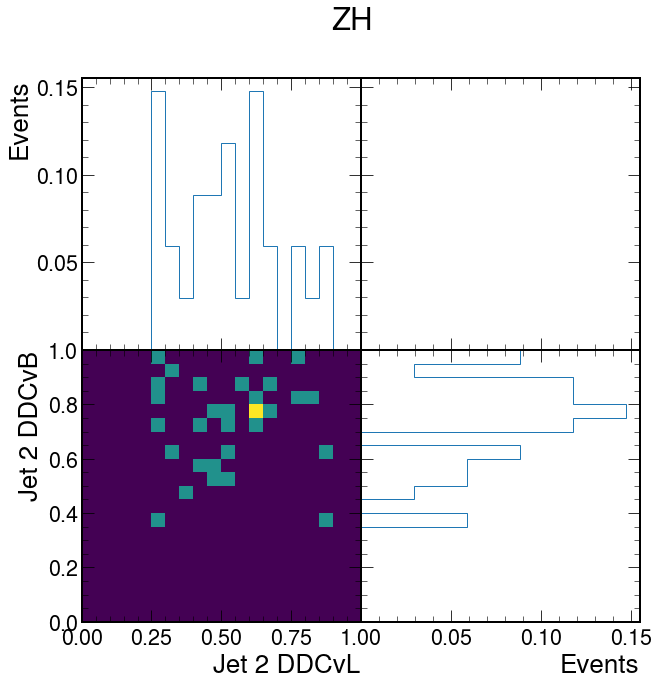

In [10]:
#ZH signal
h = charm_scores.sum('msd1','ddb1','msd2','ddb2').integrate('region','signal').integrate('process','ZH')

fig, ax = plt.subplots(2,2,sharex='col',sharey='row')
plt.suptitle('ZH')

plt.subplots_adjust(hspace=0)
plt.subplots_adjust(wspace=0)

# ax[0,1].set_logy()
# ax[0,1].set_logx()

xprojection = hist.export1d(h.integrate('ddcvb2')).numpy()
yprojection = hist.export1d(h.integrate('ddcvl2')).numpy()

bins = yprojection[1]

ax[1,1].hist(bins[:-1],
             weights=yprojection[0],
             bins=bins,
             histtype='step',
             orientation='horizontal')
ax[1,1].set_xlabel('Events')

ax[0,0].hist(bins[:-1],
             weights=xprojection[0],
             bins=bins,
             histtype='step')
ax[0,0].set_ylabel('Events')

#Remove overlapping ticks 
yticks_0 = ax[0,0].yaxis.get_major_ticks()
yticks_0[0].set_visible(False)

xticks_1 = ax[1,1].xaxis.get_major_ticks()
xticks_1[0].set_visible(False)

yticks_01 = ax[0,1].yaxis.get_major_ticks()
yticks_01[-1].set_visible(False)


X, Y = np.meshgrid(bins[:-1],bins[:-1])
w = h.values()[()]

ax[1,0].hist2d(X.flatten(),Y.flatten(),weights=w.flatten(),bins=bins)
ax[1,0].set_xlabel('Jet 2 DDCvL')
ax[1,0].set_ylabel('Jet 2 DDCvB')

## 2. Plots for WH sample

* Year: 2017
* Index: 2649

### NOTE THAT this section's codes should run independently of the previous section! To run please reset the kernel: (kernel -> restart)

In [2]:
#ZH signal sample
year = '2017'
n=2649 #File index
outsum = processor.dict_accumulator()
picklename = 'pickles/{}_{}_CScores.pkl'.format(year,n)
filename = 'outfiles/{}_{}.coffea'.format(year,n)

In [3]:
#Repickle the file (since we're using a single test output)
with open('../infiles-split/'+year+'_'+str(n)+'.json') as f:
            infiles = json.load(f)

#Load the coffea file
out = util.load(filename)
outsum.add(out)

#Scaling luminosity 
scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
outsum['charm-scores'].scale(scale_lumi, 'dataset')

# Use pmap to group the datasets together
charm_scores = outsum['charm-scores'].group('dataset', hist.Cat('process', 'Process'), pmap)

#Write the pickles output file
outfile = open(picklename, 'wb')
pickle.dump(charm_scores, outfile, protocol=-1)
outfile.close()

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:376: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7ff922501b80>
  warnings.warn(


In [4]:
# Read the histogram from the pickle file
charm_scores = pickle.load(open(picklename,'rb'))

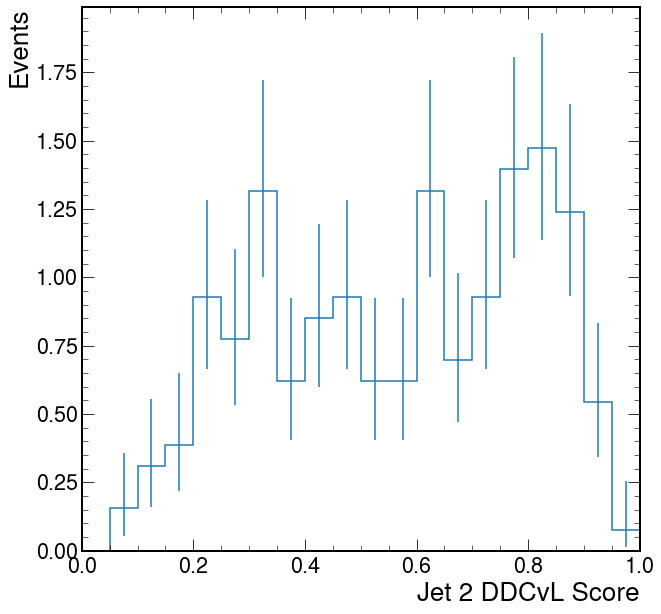

In [6]:
# check intergrals
hist.plot1d(charm_scores.sum('ddcvb1','ddcvl1','ddcvb2').integrate('process','WH'))
plt.legend([])

Text(0, 1, 'Jet 2 DDCvB')

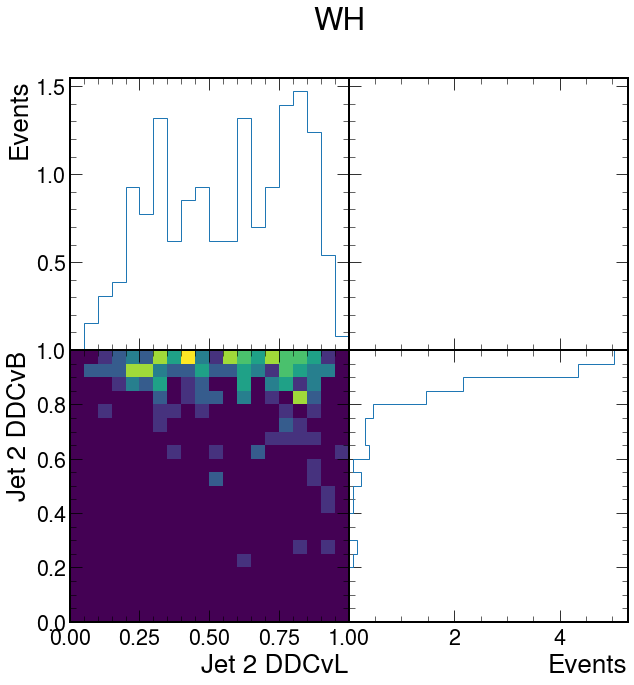

In [7]:
h = charm_scores.sum('ddcvb1','ddcvl1').integrate('process','WH')

fig, ax = plt.subplots(2,2,sharex='col',sharey='row')
plt.suptitle('WH')

plt.subplots_adjust(hspace=0)
plt.subplots_adjust(wspace=0)

# ax[0,1].set_logy()
# ax[0,1].set_logx()

xprojection = hist.export1d(h.integrate('ddcvb2')).numpy()
yprojection = hist.export1d(h.integrate('ddcvl2')).numpy()

bins = yprojection[1]

ax[1,1].hist(bins[:-1],
             weights=yprojection[0],
             bins=bins,
             histtype='step',
             orientation='horizontal')
ax[1,1].set_xlabel('Events')

ax[0,0].hist(bins[:-1],
             weights=xprojection[0],
             bins=bins,
             histtype='step')
ax[0,0].set_ylabel('Events')

#Remove overlapping ticks 
yticks_0 = ax[0,0].yaxis.get_major_ticks()
yticks_0[0].set_visible(False)

xticks_1 = ax[1,1].xaxis.get_major_ticks()
xticks_1[0].set_visible(False)

yticks_01 = ax[0,1].yaxis.get_major_ticks()
yticks_01[-1].set_visible(False)


X, Y = np.meshgrid(bins[:-1],bins[:-1])
w = h.values()[()]

ax[1,0].hist2d(X.flatten(),Y.flatten(),weights=w.flatten(),bins=bins)
ax[1,0].set_xlabel('Jet 2 DDCvL')
ax[1,0].set_ylabel('Jet 2 DDCvB')